# EDA - Categorical variables

The following notebook performs exploratory data analysis on categorical variables

## Contents

- [Month](#month)
- [Operating systems](#os)
- [Browser](#browser)
- [Region](#region)
- [Traffic Type](#traffic)
- [Visitor Type](#visitor)
- [Weekend](#weekend)
- [Summary](#summary)

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import calendar
from scipy import stats
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from Utils.DataUtils import *
from Utils.VizUtils import *

In [3]:
train_data = pd.read_csv("./train_data.csv")
display(
    train_data.shape,
    train_data.head()
)

(8543, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,11,604.73,0,0.0,63,1276.843158,0.0000,0.006712,0.000000,0.0,Jul,2,2,8,6,New_Visitor,False,True
1,1,59.50,0,0.0,20,646.166667,0.0000,0.025333,0.000000,0.0,Dec,2,2,9,3,Returning_Visitor,False,False
2,4,82.50,0,0.0,16,299.500000,0.0000,0.005556,0.000000,0.0,Dec,1,1,4,2,Returning_Visitor,True,False
3,0,0.00,0,0.0,8,704.166667,0.0125,0.035417,0.000000,0.0,Nov,3,2,1,3,Returning_Visitor,False,False
4,1,153.50,0,0.0,20,1002.847222,0.0000,0.009524,41.134331,0.0,Nov,2,2,4,2,Returning_Visitor,False,False


In [4]:
# Quick helper variable
rev_palette = {True:'cornflowerblue', False:'mistyrose'}

def chisq_ind_test(df, col1, col2, alpha=0.05, debug=True, print_result=True):
    contingency_table = pd.crosstab(df[col1],df[col2],margins = False)
    if debug:
        print("Contingency table:\n", contingency_table)
    stat, p, dof, expected = chi2_contingency(contingency_table)
    if debug:
        print("Statistic:", stat)
        print("P-value:", p)
        print("DOF:", dof)
    critical = chi2.ppf(1-alpha, dof)
    
    if print_result:
        if debug:
            print('probability=%.3f, critical=%.3f, stat=%.3f' % (1-alpha, critical, stat))
        if abs(stat) >= critical:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')
        # interpret p-value
        if debug:
            print('significance=%.3f, p=%.3f' % (alpha, p))
        if p <= alpha:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')
    
    return stat, p, dof

In [5]:
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend"]
train_data[cat_cols+["Revenue"]].head()

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,Jul,2,2,8,6,New_Visitor,False,True
1,Dec,2,2,9,3,Returning_Visitor,False,False
2,Dec,1,1,4,2,Returning_Visitor,True,False
3,Nov,3,2,1,3,Returning_Visitor,False,False
4,Nov,2,2,4,2,Returning_Visitor,False,False


--------

#  Month<a id='month'></a>

What months do most sales happen?

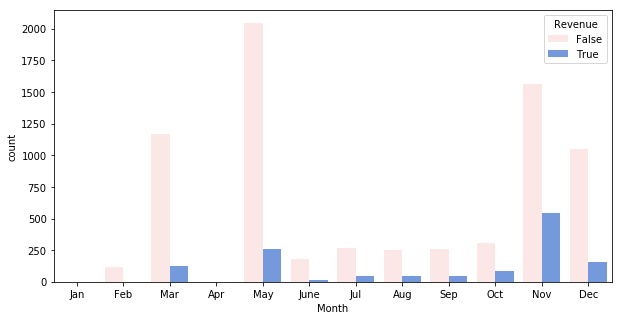

In [6]:
months = [calendar.month_name[i][:3] for i in range(1,13)]
months[5] = "June"

f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["Month"], data=train_data, order=months, hue="Revenue", palette=rev_palette)

In [7]:
train_data["Month"].value_counts()

May     2306
Nov     2110
Mar     1288
Dec     1206
Oct      393
Jul      316
Sep      305
Aug      304
June     198
Feb      117
Name: Month, dtype: int64

,Revenue,Month,count,count_norm
0,False,Aug,255,0.838816
1,False,Dec,1048,0.868988
2,False,Feb,115,0.982906
3,False,Jul,268,0.848101
4,False,June,181,0.914141
5,False,Mar,1165,0.904503
6,False,May,2045,0.886817
7,False,Nov,1565,0.741706
8,False,Oct,309,0.786260
9,False,Sep,256,0.839344


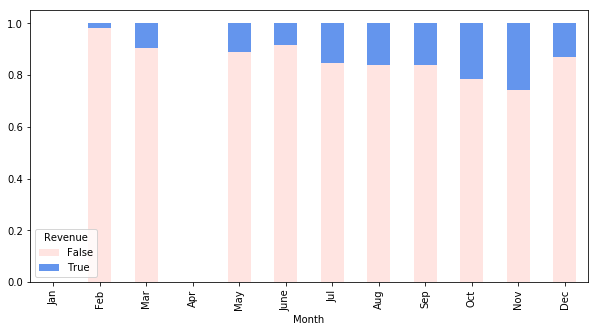

In [7]:
tmp = train_data[["Revenue", "Month"]]
tmp["count"] = 1
tmp = tmp.groupby(["Revenue", "Month"], as_index=False).count()
tmp["count_norm"] = 1
def get_norm_count(row):
    q = "Month==\""+row["Month"]+"\""
    val = tmp.query(q)["count"].sum()
    row["count_norm"] = row["count"]/val
    return row
tmp = tmp.apply(get_norm_count, axis=1)
display(tmp)
tmp.pivot(columns="Revenue", index="Month", values="count_norm").loc[months,:].plot.bar(stacked=True, color=['mistyrose', 'cornflowerblue'], figsize=(10,5))

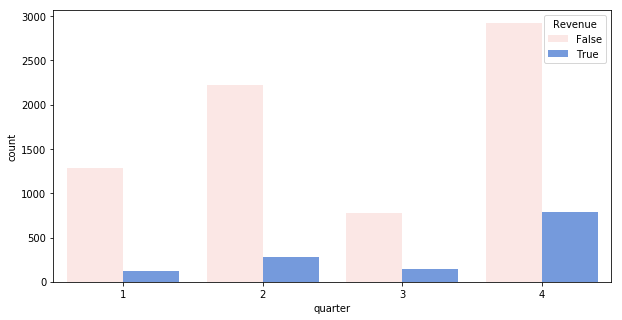

In [77]:
train_data["quarter"] = train_data["Month"].apply(lambda x: 1+np.floor(months.index(x)/3)).astype(np.uint8)
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["quarter"], data=train_data, hue="Revenue", palette=rev_palette)

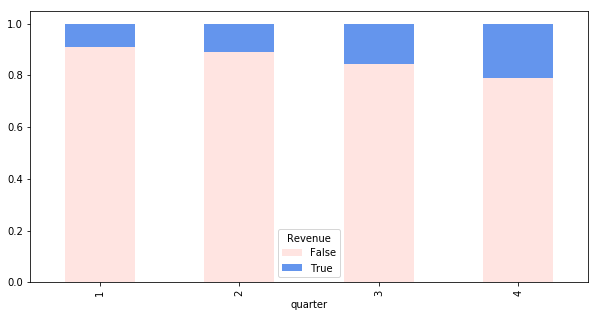

In [82]:
tmp = train_data[["Revenue", "quarter"]]
tmp["count"] = 1
tmp = tmp.groupby(["Revenue", "quarter"], as_index=False).count()
tmp["count_norm"] = 1
def get_norm_count(row):
    q = "quarter==\""+str(row["quarter"])+"\""
    val = tmp.query(q)["count"].sum()
    row["count_norm"] = row["count"]/val
    return row
tmp = tmp.apply(get_norm_count, axis=1)
tmp.pivot(columns="Revenue", index="quarter", values="count_norm").plot.bar(stacked=True, color=['mistyrose', 'cornflowerblue'], figsize=(10,5))

Is there any association between these Month and Revenue?

In [8]:
stat, p, dof = chisq_ind_test(train_data, 'Month', 'Revenue', 0.05)

Contingency table:
 Revenue  False  True 
Month                
Aug        255     49
Dec       1048    158
Feb        115      2
Jul        268     48
June       181     17
Mar       1165    123
May       2045    261
Nov       1565    545
Oct        309     84
Sep        256     49
Statistic: 275.41575258740664
P-value: 4.227059349713266e-54
DOF: 9
probability=0.950, critical=16.919, stat=275.416
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Since the null hypothesis is rejected, Month and Revenue are not independent.

--------

#  OperatingSystems<a id='os'></a>

Do operating systems play a role on Revenue generation?

In [9]:
display(100*train_data["OperatingSystems"].value_counts()/train_data.shape[0])

2    53.423856
3    20.894299
1    20.788950
4     3.991572
8     0.608685
6     0.163877
5     0.070233
7     0.058527
Name: OperatingSystems, dtype: float64

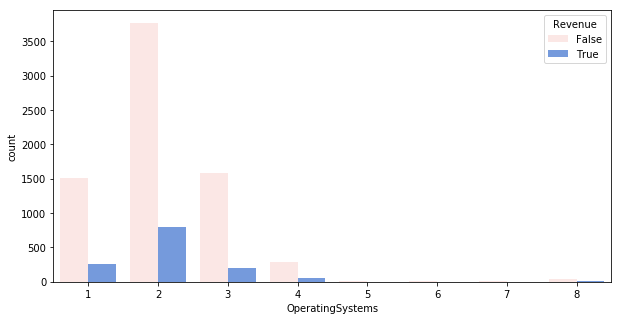

In [10]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["OperatingSystems"], data=train_data, hue="Revenue", palette=rev_palette)

There is a very strong skew to the right, with Operating Systems 5,6,7 and 8 having less than 1% of prevalence. 

We can club operating systems 4 through 8 into a new category.

In [10]:
train_data["OperatingSystems_agg"] = train_data["OperatingSystems"].apply(lambda x: "other" if x >=4 else x)
display(100*train_data["OperatingSystems_agg"].value_counts()/train_data.shape[0])

2        53.423856
3        20.894299
1        20.788950
other     4.892895
Name: OperatingSystems_agg, dtype: float64

Now let's visualize contributions again

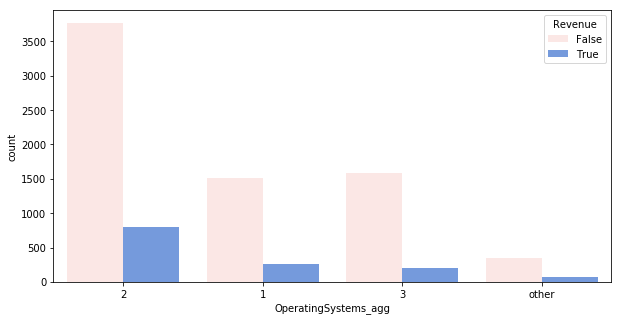

In [11]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["OperatingSystems_agg"], data=train_data, hue="Revenue", palette=rev_palette)

In [12]:
stat, p, dof = chisq_ind_test(train_data, 'OperatingSystems_agg', 'Revenue', 0.05)

Contingency table:
 Revenue               False  True 
OperatingSystems_agg              
1                      1512    264
2                      3767    797
3                      1583    202
other                   345     73
Statistic: 38.64764150810362
P-value: 2.061119943186212e-08
DOF: 3
probability=0.950, critical=7.815, stat=38.648
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Since the null hypothesis is rejected, Operating Systems (agg) and Revenue are not independent.

--------

# Browser<a id='browser'></a>

What is the distribution of browsers in the dataset?

In [60]:
display((pd.DataFrame(100*train_data["Browser"].value_counts()/train_data.shape[0]).sort_index()))

,Browser
1,19.840805
2,64.626010
3,0.889617
4,5.782512
5,3.780873
6,1.428070
7,0.468220
8,1.135433
9,0.011705
10,1.416364


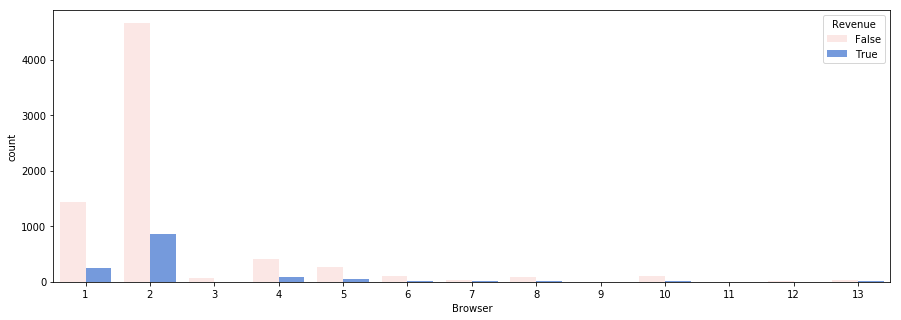

In [8]:
f, ax = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x=train_data["Browser"], data=train_data, hue="Revenue", palette=rev_palette)

Similar to Operating Systems, we can aggregate some of the less prevalent ones together.

In [9]:
train_data["Browser_agg"] = train_data["Browser"].apply(lambda x: "other" if x not in [1,2,4] else x)
display(pd.DataFrame(100*train_data["Browser_agg"].value_counts()/train_data.shape[0]))

,Browser_agg
2,64.626010
1,19.840805
other,9.750673
4,5.782512


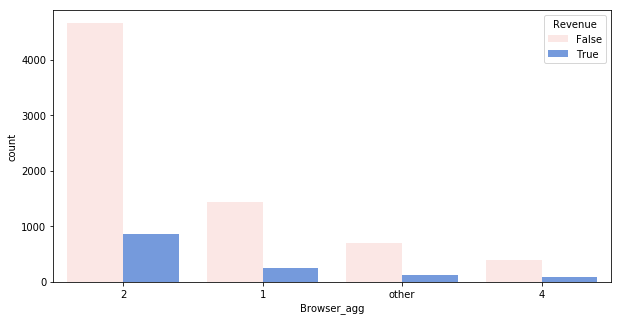

In [10]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["Browser_agg"], data=train_data, hue="Revenue", palette=rev_palette)

,Revenue,Browser_agg,count,count_norm
0,False,1,1442,0.850737
1,False,2,4659,0.843869
2,False,4,403,0.815789
3,False,other,703,0.843938
4,True,1,253,0.149263
5,True,2,862,0.156131
6,True,4,91,0.184211
7,True,other,130,0.156062


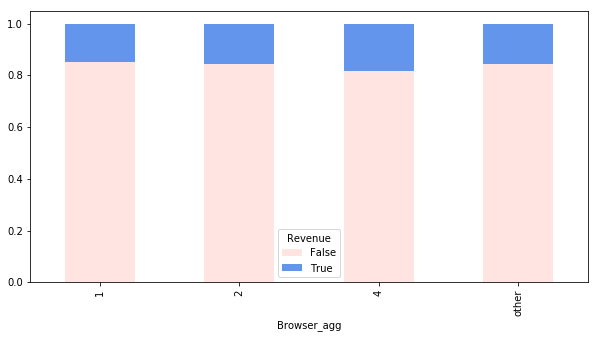

In [11]:
tmp = train_data[["Revenue", "Browser_agg"]]
tmp["Browser_agg"] = tmp["Browser_agg"].astype(str)
tmp["count"] = 1
tmp = tmp.groupby(["Revenue", "Browser_agg"], as_index=False).count()
tmp["count_norm"] = 1
def get_norm_count(row):
    q = "Browser_agg==\""+row["Browser_agg"]+"\""
    val = tmp.query(q)["count"].sum()
    row["count_norm"] = row["count"]/val
    return row
tmp = tmp.apply(get_norm_count, axis=1)
display(tmp)
tmp.pivot(columns="Revenue", index="Browser_agg", values="count_norm").plot.bar(stacked=True, color=['mistyrose', 'cornflowerblue'], figsize=(10,5))

In [16]:
stat, p, dof = chisq_ind_test(train_data, 'Browser_agg', 'Revenue', 0.05)

Contingency table:
 Revenue      False  True 
Browser_agg              
1             1442    253
2             4659    862
4              403     91
other          703    130
Statistic: 3.554286536239366
P-value: 0.313789291724429
DOF: 3
probability=0.950, critical=7.815, stat=3.554
Independent (fail to reject H0)
significance=0.050, p=0.314
Independent (fail to reject H0)


The test states that the Browser (agg) and Revenue are independent of each other

###  Do Browser and Operating system have a strong association as well?

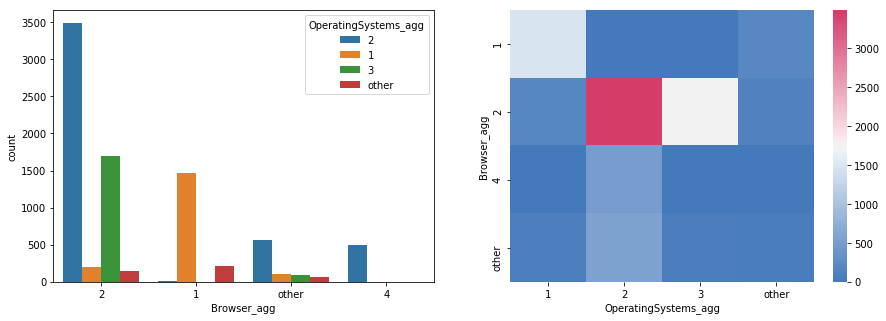

In [17]:
f, ax = plt.subplots(1,2,figsize=(15,5))
g = sns.countplot(x=train_data["Browser_agg"], data=train_data, hue="OperatingSystems_agg", ax=ax[0])
cutsomcmap = sns.diverging_palette(250, 0, as_cmap=True)
heat_map = sns.heatmap(pd.crosstab(train_data["Browser_agg"], train_data["OperatingSystems_agg"]), cmap=cutsomcmap, ax=ax[1])

In [18]:
stat, p, dof = chisq_ind_test(train_data, 'Browser_agg', 'OperatingSystems_agg', 0.05)

Contingency table:
 OperatingSystems_agg     1     2     3  other
Browser_agg                                  
1                     1474    13     0    208
2                      196  3488  1691    146
4                        1   492     0      1
other                  105   571    94     63
Statistic: 6722.363413254109
P-value: 0.0
DOF: 9
probability=0.950, critical=16.919, stat=6722.363
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


The Browser and Operating system are not independent.

--------

# Region<a id='region'></a>

In [19]:
display((100*train_data["Region"].value_counts()/train_data.shape[0]).sort_index())

1    38.370596
2     9.048344
3    19.793983
4     9.879433
5     2.528386
6     6.391197
7     6.239026
8     3.511647
9     4.237387
Name: Region, dtype: float64

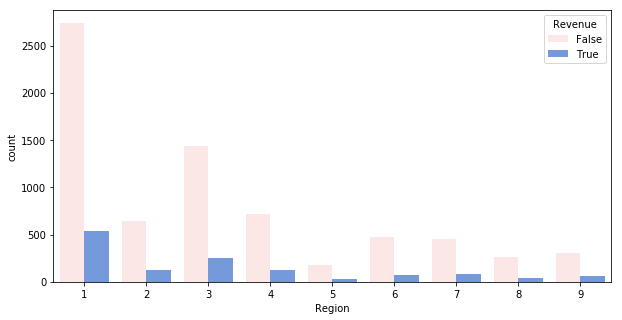

In [20]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["Region"], data=train_data, hue="Revenue", palette=rev_palette)

,Revenue,Region,count,count_norm
0,False,1,2739,0.835570
1,False,2,643,0.831824
2,False,3,1438,0.850384
3,False,4,720,0.853081
4,False,5,182,0.842593
5,False,6,470,0.860806
6,False,7,451,0.846154
7,False,8,262,0.873333
8,False,9,302,0.834254
9,True,1,539,0.164430


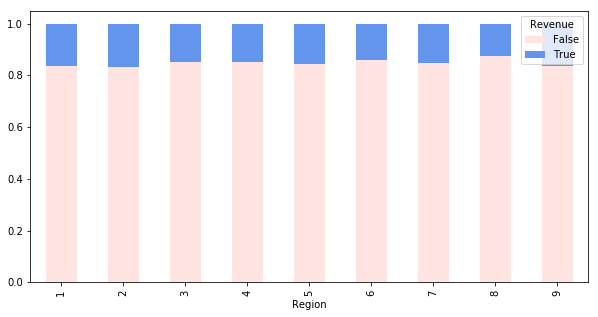

In [12]:
tmp = train_data[["Revenue", "Region"]]
tmp["Region"] = tmp["Region"].astype(str)
tmp["count"] = 1
tmp = tmp.groupby(["Revenue", "Region"], as_index=False).count()
tmp["count_norm"] = 1
def get_norm_count(row):
    q = "Region==\""+row["Region"]+"\""
    val = tmp.query(q)["count"].sum()
    row["count_norm"] = row["count"]/val
    return row
tmp = tmp.apply(get_norm_count, axis=1)
display(tmp)
tmp.pivot(columns="Revenue", index="Region", values="count_norm").plot.bar(stacked=True, color=['mistyrose', 'cornflowerblue'], figsize=(10,5))

In [21]:
stat, p, dof = chisq_ind_test(train_data, 'Region', 'Revenue', 0.05)

Contingency table:
 Revenue  False  True 
Region               
1         2739    539
2          643    130
3         1438    253
4          720    124
5          182     34
6          470     76
7          451     82
8          262     38
9          302     60
Statistic: 7.082623717510663
P-value: 0.5277450373140861
DOF: 8
probability=0.950, critical=15.507, stat=7.083
Independent (fail to reject H0)
significance=0.050, p=0.528
Independent (fail to reject H0)


The Chi square test fails to reject the null hypothesis, stating that Region is independent of Revenue.

--------

# TrafficType<a id='traffic'></a>

In [16]:
display(pd.DataFrame((100*train_data["TrafficType"].value_counts()/train_data.shape[0]).sort_index()))

,TrafficType
1,19.267236
2,32.693433
3,16.375980
4,8.568419
5,2.212338
6,3.558469
7,0.351165
8,2.821023
9,0.304343
10,3.558469


Let's aggregate all the Traffic Types that contribute less than 2% together.

In [23]:
traffic_type_pct = 100*train_data["TrafficType"].value_counts().to_frame()/train_data.shape[0]
idx_list = traffic_type_pct[traffic_type_pct["TrafficType"] < 2].index
train_data["TrafficType_agg"] = train_data["TrafficType"].apply(lambda x: "other" if x in idx_list else x)
display(100*train_data["TrafficType_agg"].value_counts().to_frame()/train_data.shape[0])

,TrafficType_agg
2,32.693433
1,19.267236
3,16.375980
4,8.568419
13,6.004916
10,3.558469
6,3.558469
other,2.914667
8,2.821023
5,2.212338


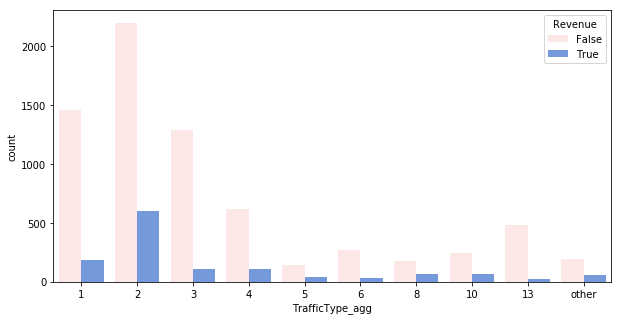

In [24]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["TrafficType_agg"], data=train_data, hue="Revenue", palette=rev_palette, order=[1,2,3,4,5,6,8,10,13,'other'])

In [25]:
stat, p, dof = chisq_ind_test(train_data, 'TrafficType_agg', 'Revenue', 0.05)

Contingency table:
 Revenue          False  True 
TrafficType_agg              
1                 1461    185
2                 2194    599
3                 1287    112
4                  619    113
5                  147     42
6                  268     36
8                  173     68
10                 241     63
11                 139     34
13                 485     28
other              193     56
Statistic: 253.019769414731
P-value: 1.2577121742696573e-48
DOF: 10
probability=0.950, critical=18.307, stat=253.020
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


The Chi square test rejects the null hypothesis, stating that TrafficType (agg) has an association with Revenue.

--------

# Visitor Type<a id='visitor'></a>

--------

In [26]:
display((100*train_data["VisitorType"].value_counts()/train_data.shape[0]).sort_index())

New_Visitor          14.386047
Other                 0.632096
Returning_Visitor    84.981856
Name: VisitorType, dtype: float64

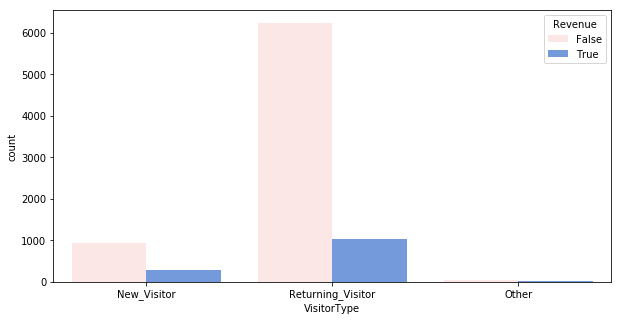

In [27]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x=train_data["VisitorType"], data=train_data, hue="Revenue", palette=rev_palette)

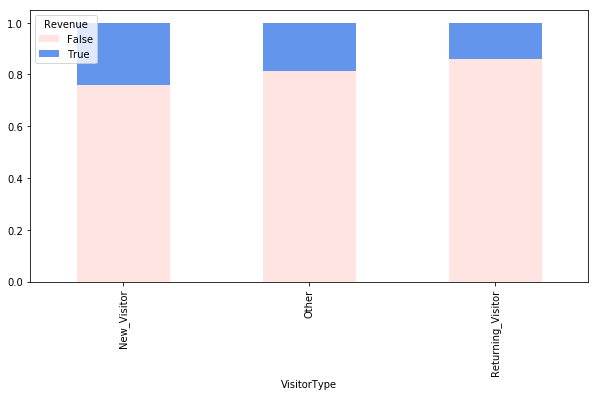

In [74]:
tmp = train_data[["Revenue", "VisitorType"]]
tmp["VisitorType"] = tmp["VisitorType"].astype(str)
tmp["count"] = 1
tmp = tmp.groupby(["Revenue", "VisitorType"], as_index=False).count()
tmp["count_norm"] = 1
def get_norm_count(row):
    q = "VisitorType==\""+row["VisitorType"]+"\""
    val = tmp.query(q)["count"].sum()
    row["count_norm"] = row["count"]/val
    return row
tmp = tmp.apply(get_norm_count, axis=1)
tmp.pivot(columns="Revenue", index="VisitorType", values="count_norm").plot.bar(stacked=True, color=['mistyrose', 'cornflowerblue'], figsize=(10,5))

In [28]:
stat, p, dof = chisq_ind_test(train_data, 'VisitorType', 'Revenue', 0.05)

Contingency table:
 Revenue            False  True 
VisitorType                    
New_Visitor          931    298
Other                 44     10
Returning_Visitor   6232   1028
Statistic: 81.4126377933747
P-value: 2.0963815292451966e-18
DOF: 2
probability=0.950, critical=5.991, stat=81.413
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Visitor type and Revenue have a strong association with each other.

--------

# Weekend<a id='weekend'></a>

In [29]:
display((100*train_data["Weekend"].value_counts()/train_data.shape[0]).sort_index())

False    76.928479
True     23.071521
Name: Weekend, dtype: float64

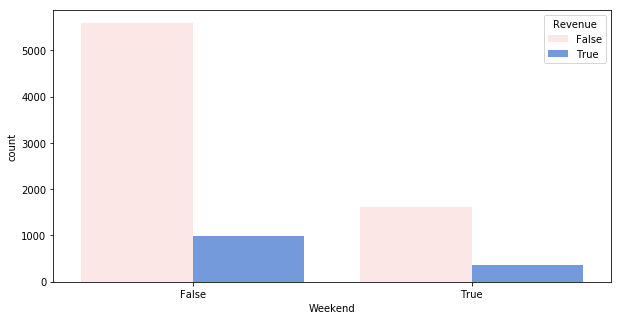

In [30]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x="Weekend", data=train_data, hue="Revenue", palette=rev_palette)

In [31]:
stat, p, dof = chisq_ind_test(train_data, 'Weekend', 'Revenue', 0.05)

Contingency table:
 Revenue  False  True 
Weekend              
False     5589    983
True      1618    353
Statistic: 9.79482998316253
P-value: 0.001750031903416694
DOF: 1
probability=0.950, critical=3.841, stat=9.795
Dependent (reject H0)
significance=0.050, p=0.002
Dependent (reject H0)


A weekend may also be a strong predictor of Revenue generation for a session.

--------

Let's make a dataframe with the categorical features alongside their Chisq statistic and p-values for summary

In [32]:
chisq_dict = {"column":[], 
             "chisq_stat":[],
             "pval":[],
#              "dof":[]
             }
for c in cat_cols+["quarter", "Browser_agg", "TrafficType_agg", "OperatingSystems_agg"]:
    print(c, end=" --> ")
    stat, p, dof = chisq_ind_test(train_data, c, "Revenue", debug=False, print_result=False)
    chisq_dict["column"].append(c)
    chisq_dict["chisq_stat"].append(stat)
    chisq_dict["pval"].append(np.round(p, 4))
#     chisq_dict["dof"].append(dof)

def highlight_weakpred(x):
    return ['background-color: salmon' if x["pval"] > 0.05
            else ''
            for i in x]

pd.DataFrame(chisq_dict).style.apply(highlight_weakpred, axis=1)

Month --> OperatingSystems --> Browser --> Region --> TrafficType --> VisitorType --> Weekend --> quarter --> Browser_agg --> TrafficType_agg --> OperatingSystems_agg --> 

,column,chisq_stat,pval
0,Month,275.416,0
1,OperatingSystems,42.1854,0
2,Browser,22.5624,0.0317
3,Region,7.08262,0.5277
4,TrafficType,275.996,0
5,VisitorType,81.4126,0
6,Weekend,9.79483,0.0018
7,quarter,175.015,0
8,Browser_agg,3.55429,0.3138
9,TrafficType_agg,253.02,0


In [33]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

ctest = {"col":[],"cv":[]}
for c in cat_cols+["quarter", "Browser_agg", "TrafficType_agg", "OperatingSystems_agg"]:
    cv = cramers_v(train_data[c], train_data["Revenue"])
    ctest["col"].append(c)
    ctest["cv"].append(cv)
pd.DataFrame(ctest).sort_values("cv", ascending=False)

,col,cv
0,Month,0.176604
4,TrafficType,0.173790
9,TrafficType_agg,0.168671
7,quarter,0.141907
5,VisitorType,0.096419
10,OperatingSystems_agg,0.064600
1,OperatingSystems,0.064180
2,Browser,0.035162
6,Weekend,0.032087
8,Browser_agg,0.008053


---------

#  Summary:<a id='summary'></a>

There are some categorical variables that test positive for independence from Revenue. 

While modeling these may be filtered out based on these criteria.

- November appears to be the most active month
- TrafficType (aggregated) has predictive power

Independent Variables:
- Browser
- Region

Additional features created:
- quarter
- Browser_agg
- TrafficType_agg
- OperatingSystems_agg